In [1]:
import json
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmasher as cmr
import seaborn as sns
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
from mplsoccer import (VerticalPitch, Pitch, create_transparent_cmap,
                       FontManager, arrowhead_marker)
from matplotlib.patches import Arc
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.image as image
from matplotlib.colors import (to_rgba, LinearSegmentedColormap)
import matplotlib.patheffects as path_effects
from scipy.ndimage import gaussian_filter



from PIL import Image
from mplsoccer import Pitch, VerticalPitch, add_image

from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap

from highlight_text import fig_text
from bs4 import BeautifulSoup

from mplsoccer.cm import create_transparent_cmap
from mplsoccer.scatterutils import arrowhead_marker
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from mplsoccer.utils import FontManager
from matplotlib.patches import Arc

In [2]:
with open('copenhagen.json',encoding = "utf8") as f:
    data = json.load(f)

In [3]:
data['home'].keys()

dict_keys(['teamId', 'formations', 'stats', 'incidentEvents', 'shotZones', 'name', 'countryName', 'players', 'managerName', 'scores', 'field', 'averageAge'])

In [4]:
data['home']['formations']

[{'formationId': 2,
  'formationName': '442',
  'captainPlayerId': 77464,
  'period': 16,
  'startMinuteExpanded': 0,
  'endMinuteExpanded': 46,
  'jerseyNumbers': [31,
   7,
   21,
   8,
   3,
   14,
   26,
   20,
   19,
   9,
   10,
   6,
   16,
   17,
   18,
   25,
   33,
   47,
   80,
   82,
   97],
  'formationSlots': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'playerIds': [121774,
   128967,
   355110,
   77464,
   313171,
   122117,
   104749,
   136741,
   365409,
   315227,
   113069,
   122945,
   303139,
   73084,
   133569,
   297390,
   8155,
   331254,
   395692,
   444791,
   425406],
  'formationPositions': [{'vertical': 0.0, 'horizontal': 5.0},
   {'vertical': 2.5, 'horizontal': 1.0},
   {'vertical': 2.5, 'horizontal': 9.0},
   {'vertical': 6.0, 'horizontal': 3.5},
   {'vertical': 2.5, 'horizontal': 3.5},
   {'vertical': 2.5, 'horizontal': 6.5},
   {'vertical': 6.0, 'horizontal': 1.0}

In [5]:
df = pd.json_normalize(data['events'], sep='_')
df = df[['id', 'playerId', 'teamId', 'eventId', 'minute', 'second', 'type_displayName', 
         'outcomeType_displayName', 'x', 'y', 'endX', 'endY', 'isTouch']]
df.head()

,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch
0,2.467643e+09,NaN,167,2,0,0,Start,Successful,0.0,0.0,NaN,NaN,False
1,2.467643e+09,NaN,10,2,0,0,Start,Successful,0.0,0.0,NaN,NaN,False
2,2.467643e+09,383798.0,10,3,0,0,Pass,Successful,50.0,50.0,29.6,47.6,True
3,2.467643e+09,345018.0,10,4,0,3,Pass,Unsuccessful,29.6,47.6,96.9,38.9,True
4,2.467643e+09,121774.0,167,3,0,7,KeeperPickup,Successful,1.9,60.0,NaN,NaN,False


In [6]:
df.type_displayName.unique()

array(['Start', 'Pass', 'KeeperPickup', 'Clearance', 'BallTouch',
       'TakeOn', 'Tackle', 'CornerAwarded', 'SavedShot', 'BallRecovery',
       'MissedShots', 'Aerial', 'BlockedPass', 'Goal', 'Interception',
       'Dispossessed', 'Foul', 'Claim', 'Save', 'Challenge',
       'ChanceMissed', 'End', 'SubstitutionOff', 'SubstitutionOn',
       'FormationChange', 'Card', 'PenaltyFaced', 'ShotOnPost',
       'FormationSet'], dtype=object)

In [7]:
team_dict  = {
    data['home']['teamId']: data['home']['name'],
    data['away']['teamId']: data['away']['name']
}

player = data['home']['players'] + data['away']['players']
player_dict = {}

for i in player:
    player_dict[i['playerId']] = i['name']
    
df_player = df[df.isTouch == True]
foul_ids = df_player[df_player.playerId.isnull()].index.tolist()
df_player = df_player.drop(foul_ids)
df_player['team_name'] = df_player.teamId.apply(lambda x: team_dict[x])
df_player['player_name'] = df_player.playerId.apply(lambda x: player_dict[x])
df_player.head()

,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
2,2.467643e+09,383798.0,10,3,0,0,Pass,Successful,50.0,50.0,29.6,47.6,True,Copenhagen,Mohamed Daramy
3,2.467643e+09,345018.0,10,4,0,3,Pass,Unsuccessful,29.6,47.6,96.9,38.9,True,Copenhagen,Davit Khocholava
5,2.467643e+09,121774.0,167,4,0,9,Pass,Successful,8.5,55.8,26.1,94.4,True,Man City,Ederson
6,2.467643e+09,355110.0,167,5,0,15,Pass,Successful,36.5,89.0,46.0,96.6,True,Man City,Sergio Gómez
7,2.467643e+09,113069.0,167,6,0,16,Pass,Successful,46.0,96.6,35.1,96.5,True,Man City,Jack Grealish


In [8]:
df_player[df_player.player_name == 'Jack Grealish']

,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
7,2.467643e+09,113069.0,167,6,0,16,Pass,Successful,46.0,96.6,35.1,96.5,True,Man City,Jack Grealish
11,2.467643e+09,113069.0,167,10,0,32,Pass,Successful,76.4,95.3,69.8,82.4,True,Man City,Jack Grealish
29,2.467644e+09,113069.0,167,28,1,33,Pass,Successful,85.0,83.7,74.7,76.7,True,Man City,Jack Grealish
34,2.467644e+09,113069.0,167,33,1,44,Pass,Successful,78.5,80.1,68.2,80.0,True,Man City,Jack Grealish
43,2.467644e+09,113069.0,167,42,2,15,Pass,Successful,42.3,62.4,38.6,33.1,True,Man City,Jack Grealish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,2.467690e+09,113069.0,167,1104,87,26,Pass,Successful,55.0,26.0,42.3,41.2,True,Man City,Jack Grealish
1582,2.467690e+09,113069.0,167,1113,87,52,Pass,Successful,70.5,19.3,64.2,22.1,True,Man City,Jack Grealish
1596,2.467691e+09,113069.0,167,1126,88,39,Pass,Successful,67.7,25.7,60.2,20.0,True,Man City,Jack Grealish
1607,2.467691e+09,113069.0,167,1135,89,28,Pass,Unsuccessful,67.4,97.1,79.6,80.4,True,Man City,Jack Grealish


In [9]:
touches_df = df[df.isTouch == True]
foul_ids = touches_df[touches_df.playerId.isnull()].index.tolist()
touches_df = touches_df.drop(foul_ids)
touches_df['team_name'] = touches_df.teamId.apply(lambda x: team_dict[x])
touches_df['player_name'] = touches_df.playerId.apply(lambda x: player_dict[x])
touches_df.head()

,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
2,2.467643e+09,383798.0,10,3,0,0,Pass,Successful,50.0,50.0,29.6,47.6,True,Copenhagen,Mohamed Daramy
3,2.467643e+09,345018.0,10,4,0,3,Pass,Unsuccessful,29.6,47.6,96.9,38.9,True,Copenhagen,Davit Khocholava
5,2.467643e+09,121774.0,167,4,0,9,Pass,Successful,8.5,55.8,26.1,94.4,True,Man City,Ederson
6,2.467643e+09,355110.0,167,5,0,15,Pass,Successful,36.5,89.0,46.0,96.6,True,Man City,Sergio Gómez
7,2.467643e+09,113069.0,167,6,0,16,Pass,Successful,46.0,96.6,35.1,96.5,True,Man City,Jack Grealish


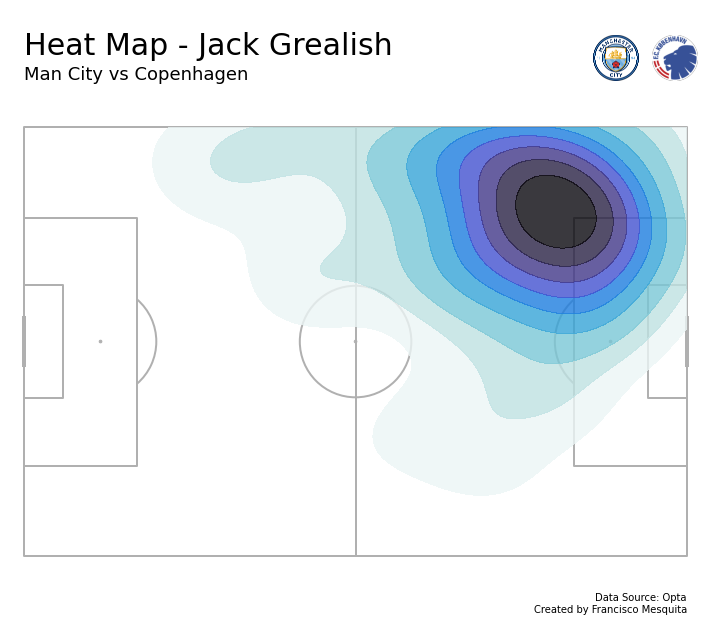

In [10]:
pitch = Pitch(pitch_type='opta')
fig, ax = pitch.grid(axis=False)
fig.set_facecolor("white")

grealish = touches_df[touches_df.player_name == 'Jack Grealish']

pitch.kdeplot(grealish.x, grealish.y, cmap=cmr.freeze_r, shade=True, alpha=0.8, ax=ax['pitch'])

ax['title'].text(0, 0.6, 'Heat Map - Jack Grealish', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

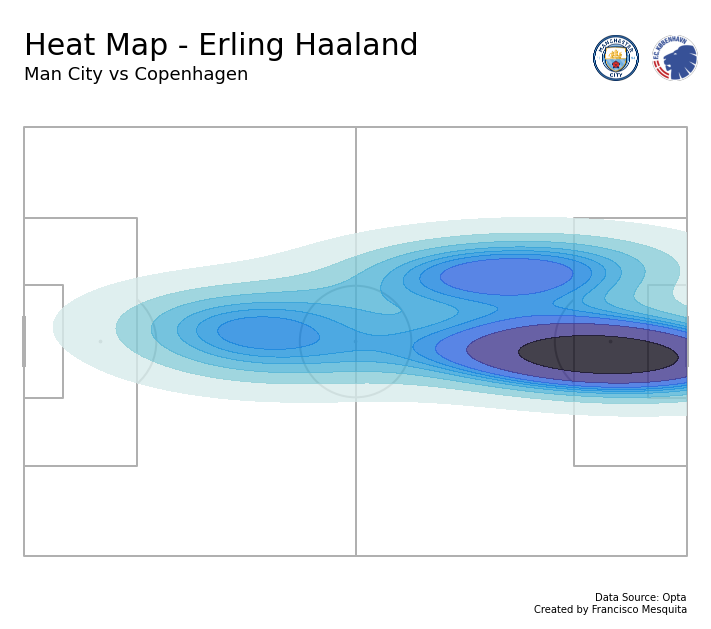

In [11]:
pitch = Pitch(pitch_type='opta')
fig, ax = pitch.grid(axis=False)
fig.set_facecolor("white")

haaland = touches_df[touches_df.player_name == 'Erling Haaland']

pitch.kdeplot(haaland.x, haaland.y, cmap=cmr.freeze_r, shade=True, alpha=0.8, ax=ax['pitch'])

ax['title'].text(0, 0.6, 'Heat Map - Erling Haaland', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

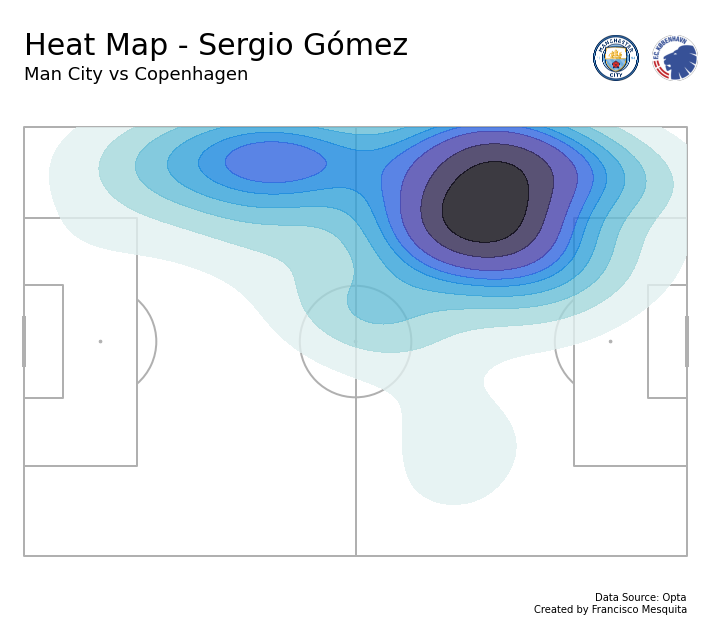

In [12]:
pitch = Pitch(pitch_type='opta')
fig, ax = pitch.grid(axis=False)
fig.set_facecolor("white")


sergi = touches_df[touches_df.player_name == 'Sergio Gómez']

pitch.kdeplot(sergi.x, sergi.y, cmap=cmr.freeze_r, shade=True, alpha=0.8, ax=ax['pitch'])

ax['title'].text(0, 0.6, 'Heat Map - Sergio Gómez', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

In [13]:
pass_data = df[df.type_displayName == 'Pass'].reset_index()
pass_data['team_name'] = pass_data.teamId.apply(lambda x: team_dict[x])
pass_data['player_name'] = pass_data.playerId.apply(lambda x: player_dict[x])
pass_data.head()

,index,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
0,2,2.467643e+09,383798.0,10,3,0,0,Pass,Successful,50.0,50.0,29.6,47.6,True,Copenhagen,Mohamed Daramy
1,3,2.467643e+09,345018.0,10,4,0,3,Pass,Unsuccessful,29.6,47.6,96.9,38.9,True,Copenhagen,Davit Khocholava
2,5,2.467643e+09,121774.0,167,4,0,9,Pass,Successful,8.5,55.8,26.1,94.4,True,Man City,Ederson
3,6,2.467643e+09,355110.0,167,5,0,15,Pass,Successful,36.5,89.0,46.0,96.6,True,Man City,Sergio Gómez
4,7,2.467643e+09,113069.0,167,6,0,16,Pass,Successful,46.0,96.6,35.1,96.5,True,Man City,Jack Grealish


In [14]:
def is_atk_third(data):
    if data.endX > 66.6 and data.x <= 66.6:
        return True
    else:
        return False

def at_atk_third(data):
    if data.x > 66.6 and data.endX > 66.6:
        return True
    else:
        return False

pass_data['to_atk_third'] = pass_data.apply(lambda x: is_atk_third(x), axis=1)
pass_data['at_atk_third'] = pass_data.apply(lambda x: at_atk_third(x), axis=1)

pass_data.head()

,index,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name,to_atk_third,at_atk_third
0,2,2.467643e+09,383798.0,10,3,0,0,Pass,Successful,50.0,50.0,29.6,47.6,True,Copenhagen,Mohamed Daramy,False,False
1,3,2.467643e+09,345018.0,10,4,0,3,Pass,Unsuccessful,29.6,47.6,96.9,38.9,True,Copenhagen,Davit Khocholava,True,False
2,5,2.467643e+09,121774.0,167,4,0,9,Pass,Successful,8.5,55.8,26.1,94.4,True,Man City,Ederson,False,False
3,6,2.467643e+09,355110.0,167,5,0,15,Pass,Successful,36.5,89.0,46.0,96.6,True,Man City,Sergio Gómez,False,False
4,7,2.467643e+09,113069.0,167,6,0,16,Pass,Successful,46.0,96.6,35.1,96.5,True,Man City,Jack Grealish,False,False


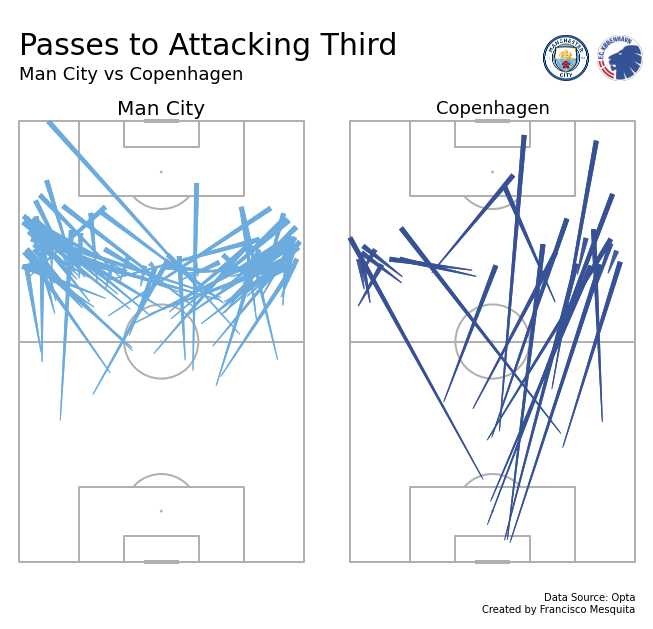

In [15]:
pitch = VerticalPitch(pitch_type='opta', half=False)
fig, ax = pitch.grid(ncols=2, axis=False)
fig.set_facecolor("white")


pass_atk = pass_data[pass_data.to_atk_third == True]

home = pass_atk[pass_atk.team_name == data['home']['name']]
pitch.lines(home.x, home.y, home.endX, home.endY, comet=True, ax=ax['pitch'][0], color='#6CABDD')
ax['pitch'][0].text(50, 103, data['home']['name'], fontsize=20, va='center', ha='center')

away = pass_atk[pass_atk.team_name == data['away']['name']]
pitch.lines(away.x, away.y, away.endX, away.endY, comet=True, ax=ax['pitch'][1], color= '#375197')
ax['pitch'][1].text(50, 103, data['away']['name'], fontsize=18, va='center', ha='center')

ax['title'].text(0, 0.6, 'Passes to Attacking Third', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

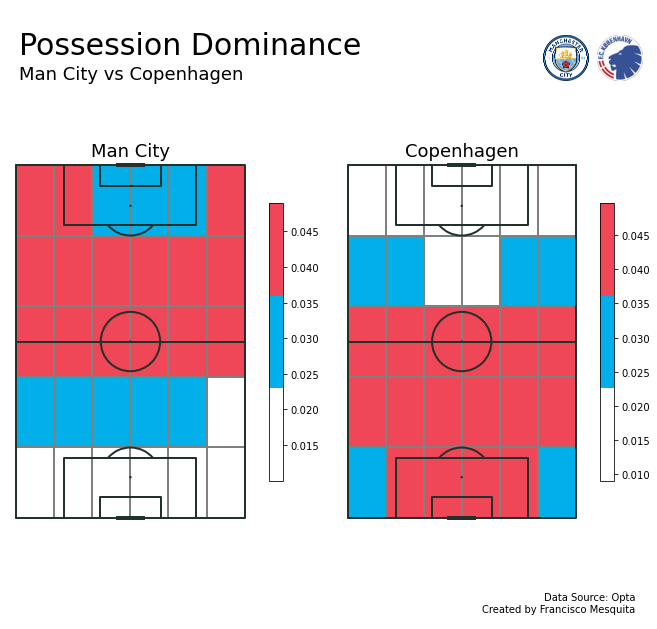

In [16]:
cmap = ListedColormap(['white', '#03afe9', '#ef4658'])

pitch = VerticalPitch(pitch_type='opta',line_color='#22312b')
fig, ax = pitch.grid(ncols=2, axis=False)
fig.set_facecolor("white")

# Home Team
home = pass_data[pass_data.team_name == data['home']['name']]
bin_statistic = pitch.bin_statistic(home.x, home.y, statistic='count', bins=(5, 6), normalize=True)
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

hm = pitch.heatmap(bin_statistic, ax=ax['pitch'][0], cmap=cmap, edgecolors='gray', zorder=0)
cbar = fig.colorbar(hm, ax=ax['pitch'][0], shrink=0.6)
ax['pitch'][0].text(50, 104, data['home']['name'], va='center', ha='center', fontsize=18)

# Away Team
home = pass_data[pass_data.team_name == data['away']['name']]
bin_statistic = pitch.bin_statistic(home.x, home.y, statistic='count', bins=(5, 6), normalize=True)
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

hm = pitch.heatmap(bin_statistic, ax=ax['pitch'][1], cmap=cmap, edgecolors='gray', zorder=0)
cbar = fig.colorbar(hm, ax=ax['pitch'][1], shrink=0.6)
ax['pitch'][1].text(50, 104, data['away']['name'], va='center', ha='center', fontsize=18)

ax['title'].text(0, 0.6, 'Possession Dominance', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

# Home
add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
# Away
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

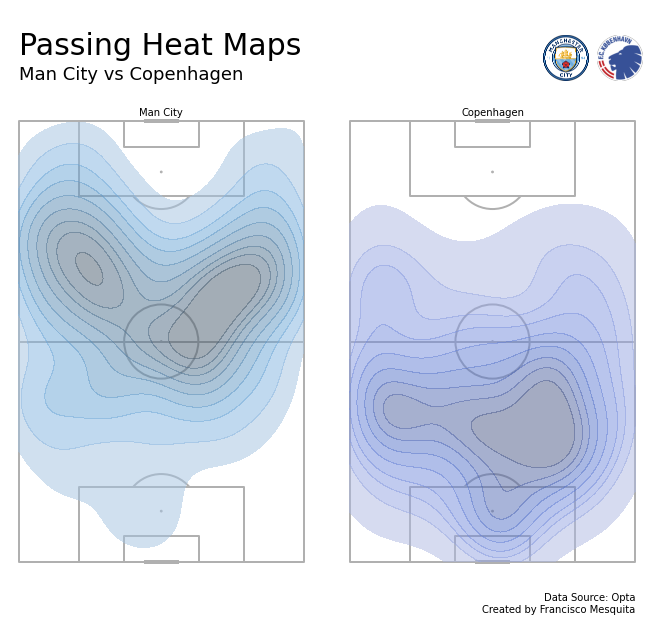

In [53]:
pitch = VerticalPitch(pitch_type='opta')
fig, ax = pitch.grid(ncols=2, axis=False)
fig.set_facecolor("white")

home = pass_data[pass_data.team_name == data['home']['name']]
pitch.kdeplot(home.x, home.y, shade=True, alpha=0.5, ax=ax['pitch'][0], color='#6CABDD')
ax['pitch'][0].text(50, 102, data['home']['name'], va='center', ha='center')


away = pass_data[pass_data.team_name == data['away']['name']]
pitch.kdeplot(away.x, away.y, shade=True, alpha=0.5, ax=ax['pitch'][1], color= '#375197')
ax['pitch'][1].text(50, 102, data['away']['name'], va='center', ha='center')

ax['title'].text(0, 0.6, 'Passing Heat Maps', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

(-0.5, 3499.5, 3499.5, -0.5)

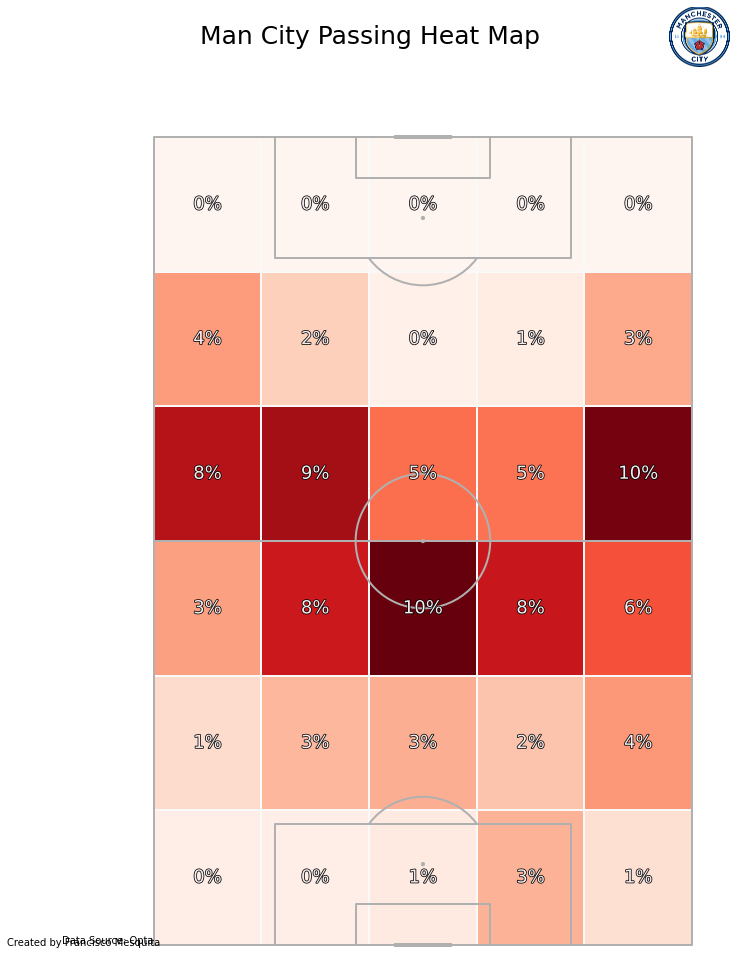

In [62]:
plt.rcParams["figure.figsize"] = [5.00, 1.50]
plt.rcParams["figure.autolayout"] = True

# path effects
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='white')
fig, ax = pitch.draw(figsize=(10, 14))
fig.set_facecolor("white")
bin_statistic = pitch.bin_statistic(home.x, home.y, statistic='count', bins=(6, 5), normalize=True)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds', edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

title1 = fig.text(x=0.5, y=1.0, s='Man City Passing Heat Map', va='center', ha='center',
                  size=25, color='black')

ax.text(0, 0.6, 'Data Source: Opta', va='center', ha='right')
ax.text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

imHD = plt.imread('mancity.png') # insert local path of the image.
newaxHD = fig.add_axes([0.9,0.97,0.1,0.06], anchor='NE', zorder=1)
newaxHD.imshow(imHD)
newaxHD.axis('off')

In [18]:
avg_pos = pass_data[['team_name', 'player_name', 'minute', 'x', 'y', 'endX', 'endY']].groupby(['team_name', 'player_name']).agg({'minute': [np.max, np.min], 'x':np.mean, 'y': np.mean}).reset_index().reset_index()
avg_pos.columns = [' '.join(col).strip() for col in avg_pos.columns.values]
avg_pos['mins_played'] = avg_pos['minute amax'] - avg_pos['minute amin']
avg_pos.head()

,index,team_name,player_name,minute amax,minute amin,x mean,y mean,mins_played
0,0,Copenhagen,Christian Sørensen,80,80,62.966667,97.366667,0
1,1,Copenhagen,Davit Khocholava,85,0,29.617241,58.334483,85
2,2,Copenhagen,Denis Vavro,89,3,32.796552,21.479310,86
3,3,Copenhagen,Hákon Haraldsson,84,55,52.350000,46.300000,29
4,4,Copenhagen,Kamil Grabara,89,3,11.393939,46.139394,86


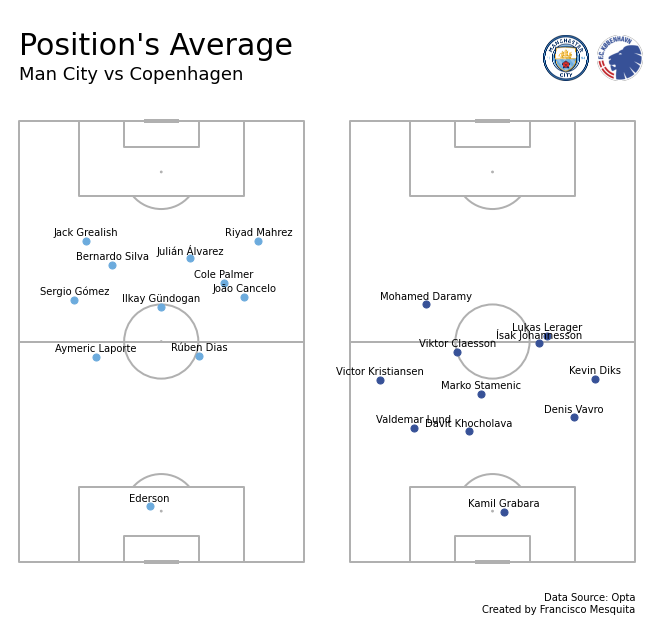

In [43]:
pitch = VerticalPitch(pitch_type='opta')
fig, ax = pitch.grid(ncols=2, axis=False)
fig.set_facecolor("white")

home = avg_pos[avg_pos.team_name == data['home']['name']]
home = home.sort_values('mins_played', ascending=False).iloc[:11, :]
pitch.scatter(home['x mean'], home['y mean'], s=50, ax=ax['pitch'][0], color='#6CABDD')

for i, d in home.iterrows():
    pitch.annotate(d['player_name'], (d['x mean'] + 2, d['y mean']), va='center', ha='center', ax=ax['pitch'][0])

away = avg_pos[avg_pos.team_name == data['away']['name']]
away = away.sort_values('mins_played', ascending=False).iloc[:11, :]
pitch.scatter(away['x mean'], away['y mean'], s=50, ax=ax['pitch'][1], color= '#375197')

for i, d in away.iterrows():
    pitch.annotate(d['player_name'], (d['x mean'] + 2, d['y mean']), va='center', ha='center', ax=ax['pitch'][1])

ax['title'].text(0, 0.6, 'Position\'s Average', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

In [20]:
team = pass_data.team_name.values.tolist()
passer = pass_data.player_name.values.tolist()
receiver = pass_data.player_name.shift(-1).tolist()
team_receiver = pass_data.team_name.shift(-1).tolist()
pass_outcome = pass_data.outcomeType_displayName.values.tolist()
x = pass_data.x.values.tolist()
y = pass_data.y.values.tolist()

pass_net_df = pd.DataFrame({
    'team': team,
    'team_receiver': team_receiver,
    'passer': passer,
    'receiver': receiver,
    'pass_outcome': pass_outcome,
    'x': x,
    'y': y
})

pass_net_df = pass_net_df[pass_net_df.pass_outcome == 'Successful']
pass_net_df = pass_net_df[pass_net_df.team == pass_net_df.team_receiver]
pass_net_df['id'] = pass_net_df['passer'] + pass_net_df['receiver']

pass_net_df.head()

,team,team_receiver,passer,receiver,pass_outcome,x,y,id
0,Copenhagen,Copenhagen,Mohamed Daramy,Davit Khocholava,Successful,50.0,50.0,Mohamed DaramyDavit Khocholava
2,Man City,Man City,Ederson,Sergio Gómez,Successful,8.5,55.8,EdersonSergio Gómez
3,Man City,Man City,Sergio Gómez,Jack Grealish,Successful,36.5,89.0,Sergio GómezJack Grealish
4,Man City,Man City,Jack Grealish,Sergio Gómez,Successful,46.0,96.6,Jack GrealishSergio Gómez
5,Man City,Man City,Sergio Gómez,Aymeric Laporte,Successful,35.2,93.5,Sergio GómezAymeric Laporte


In [21]:
pass_pair_df = pass_net_df[['passer', 'receiver', 'pass_outcome']].groupby(['passer', 'receiver']).count().reset_index()
pass_pair_df['id'] = pass_pair_df['passer'] + pass_pair_df['receiver']
pass_pair_df = pass_pair_df.sort_values('pass_outcome', ascending=False)
# pass_pair_df = pass_pair_df.drop(['passer', 'receiver'], axis=1)
pass_pair_df.head()

,passer,receiver,pass_outcome,id
9,Aymeric Laporte,Rúben Dias,36,Aymeric LaporteRúben Dias
178,Rúben Dias,Aymeric Laporte,24,Rúben DiasAymeric Laporte
194,Sergio Gómez,Jack Grealish,24,Sergio GómezJack Grealish
182,Rúben Dias,Ilkay Gündogan,19,Rúben DiasIlkay Gündogan
73,Ilkay Gündogan,João Cancelo,19,Ilkay GündoganJoão Cancelo


In [22]:
# Retrieve Top 11 Players
top_11_home = avg_pos[avg_pos.team_name == data['home']['name']].sort_values('mins_played', 
                ascending=False).player_name.tolist()[:11]
top_11_away = avg_pos[avg_pos.team_name == data['away']['name']].sort_values('mins_played', 
                ascending=False).player_name.tolist()[:11]

In [23]:
# Filter the data
avg_pos_11 = avg_pos[avg_pos.player_name.isin(top_11_home + top_11_away)].reset_index(drop=True)
avg_pos_11 = avg_pos_11.drop(['index', 'minute amax', 'minute amin', 'mins_played'], axis=1)
avg_pos_11

,team_name,player_name,x mean,y mean
0,Copenhagen,Davit Khocholava,29.617241,58.334483
1,Copenhagen,Denis Vavro,32.796552,21.479310
2,Copenhagen,Kamil Grabara,11.393939,46.139394
3,Copenhagen,Kevin Diks,41.440000,13.900000
4,Copenhagen,Lukas Lerager,51.339130,30.826087
5,Copenhagen,Marko Stamenic,38.122222,54.025926
6,Copenhagen,Mohamed Daramy,58.440000,73.206667
7,Copenhagen,Valdemar Lund,30.433333,77.655556
8,Copenhagen,Victor Kristiansen,41.282857,89.305714
9,Copenhagen,Viktor Claesson,47.642857,62.317857


In [24]:
pass_merge = pass_pair_df.merge(avg_pos_11, left_on='passer', right_on='player_name',)
pass_merge = pass_merge.rename({'x mean': 'x', 'y mean': 'y'}, axis='columns')
pass_merge = pass_merge.merge(avg_pos_11, left_on='receiver', right_on='player_name',)
pass_merge = pass_merge.rename({'x mean': 'x_end', 'y mean': 'y_end'}, axis='columns')
pass_merge = pass_merge.drop(['player_name_x', 'team_name_y', 'id', 'player_name_y'], axis=1)
pass_merge = pass_merge.rename({'team_name_x': 'team_name'}, axis='columns')

pass_merge.head()

,passer,receiver,pass_outcome,team_name,x,y,x_end,y_end
0,Aymeric Laporte,Rúben Dias,36,Man City,46.422430,72.925234,46.711905,36.799206
1,Sergio Gómez,Rúben Dias,5,Man City,59.496040,80.471287,46.711905,36.799206
2,Ilkay Gündogan,Rúben Dias,16,Man City,57.888793,50.168966,46.711905,36.799206
3,João Cancelo,Rúben Dias,12,Man City,60.185507,20.857971,46.711905,36.799206
4,Jack Grealish,Rúben Dias,5,Man City,72.778947,76.546053,46.711905,36.799206


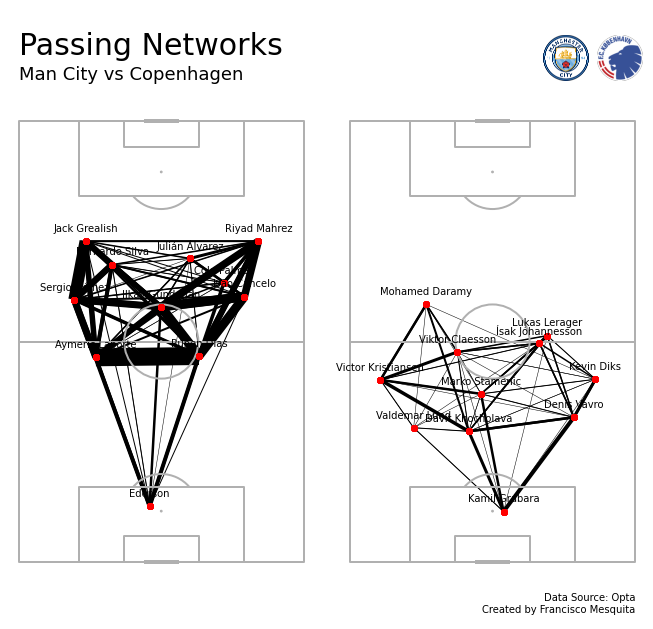

In [25]:
pitch = VerticalPitch(pitch_type='opta')
fig, ax = pitch.grid(ncols=2, axis=False)

home = pass_merge[pass_merge.team_name == data['home']['name']]

pitch.lines(home.x, home.y, home.x_end, home.y_end, color='black', 
            linewidth=home.pass_outcome * 0.5, #alpha = home.pass_outcome / home.pass_outcome.max() * 0.3, 
            zorder=0, ax=ax['pitch'][0])
pitch.scatter(home.x, home.y, color='red', ax=ax['pitch'][0])

for i, d in home[['passer', 'x', 'y']].drop_duplicates().iterrows():
    pitch.annotate(d.passer, (d.x+3, d.y), ax=ax['pitch'][0], va='center', ha='center')

away = pass_merge[pass_merge.team_name == data['away']['name']]
pitch.lines(away.x, away.y, away.x_end, away.y_end, color='black', 
            linewidth=away.pass_outcome * 0.5, #alpha = away.pass_outcome / away.pass_outcome.max() * 0.3, 
            zorder=0, ax=ax['pitch'][1])
pitch.scatter(away.x, away.y, color='red', ax=ax['pitch'][1])

for i, d in away[['passer', 'x', 'y']].drop_duplicates().iterrows():
    pitch.annotate(d.passer, (d.x+3, d.y), ax=ax['pitch'][1], va='center', ha='center')

ax['title'].text(0, 0.6, 'Passing Networks', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')


plt.show()

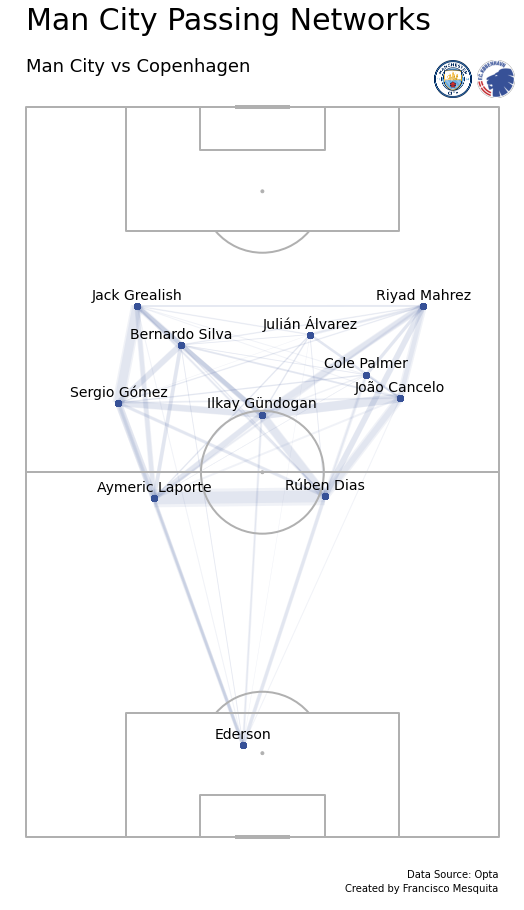

In [41]:
pitch = VerticalPitch(pitch_type='opta')
#fig, ax = pitch.grid(ncols=1, axis=False)

fig, ax = pitch.grid(figheight=13, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("white")

home = pass_merge[pass_merge.team_name == data['home']['name']]

pitch.lines(home.x, home.y, home.x_end, home.y_end, color='#375197', 
            linewidth=home.pass_outcome * 0.5, alpha = 0.07, 
            zorder=0, ax=ax['pitch'])#[0])
pitch.scatter(home.x, home.y, color='#375197', ax=ax['pitch'])#[0])

for i, d in home[['passer', 'x', 'y']].drop_duplicates().iterrows():
    pitch.annotate(d.passer, (d.x+1.5, d.y), ax=ax['pitch'], va='center', ha='center', size = 14)

ax['title'].text(0, 0.9, 'Man City Passing Networks', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

#add_image(Image.open('mancity.png'), fig, 
#          left=0.5, bottom=0.9, width=0.1, height=0.05)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.09)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.09)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')


plt.show()

In [50]:
pass_data['begin'] = pass_data.apply(lambda x: np.sqrt((100-x['x']) ** 2 + (50 - x['y'])), axis=1)
pass_data['end'] = pass_data.apply(lambda x: np.sqrt((100-x['endX']) ** 2 + (50 - x['endY'])), axis=1)
pass_data['progressive'] = pass_data.apply(lambda x: True if x.end / x.begin < .75 else False, axis=1)

pass_prog = pass_data[pass_data.progressive == True]
home = pass_prog[pass_prog.team_name == data['home']['name']]

home_succ = home[home.outcomeType_displayName == 'Successful']

away = pass_prog[pass_prog.team_name == data['away']['name']]

away_succ = away[away.outcomeType_displayName == 'Successful']

away_succ

,index,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,...,endX,endY,isTouch,team_name,player_name,to_atk_third,at_atk_third,begin,end,progressive
98,128,2.467647e+09,345018.0,10,33,7,52,Pass,Successful,36.3,...,67.3,48.8,True,Copenhagen,Davit Khocholava,True,False,63.565635,32.718343,True
190,259,2.467650e+09,364015.0,10,88,13,29,Pass,Successful,9.7,...,44.7,19.3,True,Copenhagen,Kamil Grabara,False,False,90.346500,55.576884,True
193,264,2.467650e+09,345018.0,10,91,13,35,Pass,Successful,31.1,...,49.3,52.1,True,Copenhagen,Davit Khocholava,False,False,68.880404,50.679286,True
195,266,2.467650e+09,99972.0,10,93,13,39,Pass,Successful,50.4,...,65.1,59.0,True,Copenhagen,Viktor Claesson,False,False,49.550580,34.770821,True
200,279,2.467650e+09,99972.0,10,100,13,58,Pass,Successful,68.8,...,78.3,94.1,True,Copenhagen,Viktor Claesson,False,True,30.778889,20.658896,True
265,373,2.467653e+09,232262.0,10,132,19,37,Pass,Successful,76.0,...,89.1,26.6,True,Copenhagen,Kevin Diks,False,True,25.019992,11.925183,True
444,624,2.467660e+09,345018.0,10,207,33,5,Pass,Successful,32.2,...,66.2,49.5,True,Copenhagen,Davit Khocholava,False,False,67.733596,33.807396,True
454,634,2.467660e+09,416970.0,10,217,33,32,Pass,Successful,35.4,...,63.3,81.8,True,Copenhagen,Victor Kristiansen,False,False,64.334750,36.264170,True
502,694,2.467661e+09,416970.0,10,240,36,8,Pass,Successful,28.5,...,55.7,86.1,True,Copenhagen,Victor Kristiansen,False,False,71.384522,43.890660,True
553,761,2.467663e+09,345018.0,10,278,39,47,Pass,Successful,35.4,...,64.1,19.9,True,Copenhagen,Davit Khocholava,False,False,64.676580,36.316801,True


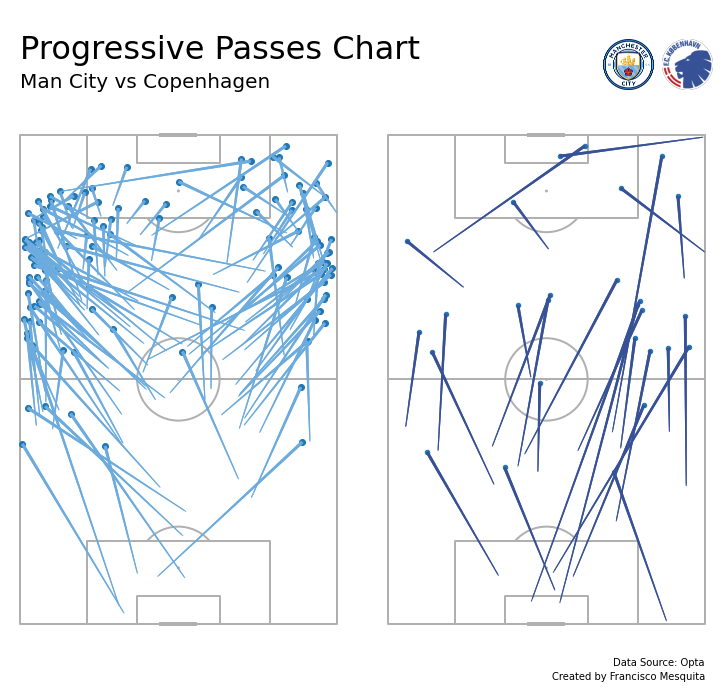

In [49]:
pitch = VerticalPitch(pitch_type='opta', line_zorder=0)
fig, ax = pitch.grid(ncols=2, axis=False, figheight=10)

fig.set_facecolor("white")

home = pass_prog[pass_prog.team_name == data['home']['name']]

home_succ = home[home.outcomeType_displayName == 'Successful']


pitch.lines(home_succ.x, home_succ.y, home_succ.endX, home_succ.endY, comet=True, linewidth=3, ax=ax['pitch'][0], color='#6CABDD')
pitch.scatter(home_succ.endX, home_succ.endY, ax=ax['pitch'][0])

away = pass_prog[pass_prog.team_name == data['away']['name']]

away_succ = away[away.outcomeType_displayName == 'Successful']

pitch.lines(away_succ.x, away_succ.y, away_succ.endX, away_succ.endY, comet=True, linewidth=3, ax=ax['pitch'][1], color= '#375197')
pitch.scatter(away_succ.endX, away_succ.endY, s=20, ax=ax['pitch'][1])

ax['title'].text(0, 0.6, 'Progressive Passes Chart', va='center', ha='left', fontsize=32)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=20)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

In [29]:
df_def = df[df.type_displayName.isin(['Clearance', 'Interception', 'BlockedPass', 'Tackle'])]
df_def['team_name'] = df_def.teamId.apply(lambda x: team_dict[x])
df_def['player_name'] = df_def.playerId.apply(lambda x: player_dict[x])
df_def.head()

,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
55,2.467644e+09,345018.0,10,5,2,43,Clearance,Successful,8.2,61.1,4.6,83.4,True,Copenhagen,Davit Khocholava
58,2.467645e+09,99972.0,10,8,2,45,Tackle,Successful,3.6,83.9,NaN,NaN,True,Copenhagen,Viktor Claesson
71,2.467645e+09,128967.0,167,61,3,16,Tackle,Successful,38.8,94.2,NaN,NaN,True,Man City,João Cancelo
85,2.467645e+09,129363.0,10,19,4,14,Clearance,Successful,9.5,47.9,16.9,65.3,True,Copenhagen,Denis Vavro
101,2.467646e+09,342577.0,10,26,5,29,BlockedPass,Successful,10.5,16.4,NaN,NaN,True,Copenhagen,Lukas Lerager


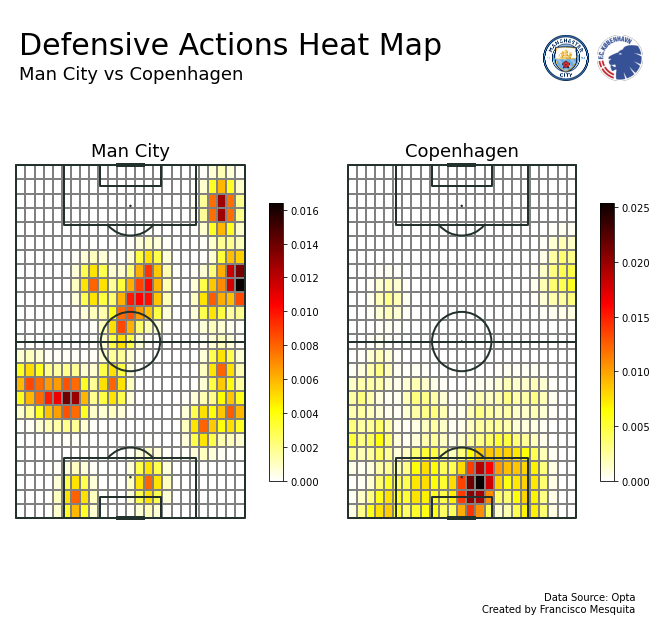

In [76]:
pitch = VerticalPitch(pitch_type='opta', line_color='#22312b')
fig, ax = pitch.grid(ncols=2, axis=False,)
fig.set_facecolor("white")

# Home Team
home = df_def[df_def.team_name == data['home']['name']]
bin_statistic = pitch.bin_statistic(home.x, home.y, statistic='count', bins=(25, 25), normalize=True)
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

hm = pitch.heatmap(bin_statistic, ax=ax['pitch'][0], cmap='hot_r', edgecolors='gray', zorder=0)
cbar = fig.colorbar(hm, ax=ax['pitch'][0], shrink=0.6)
ax['pitch'][0].text(50, 104, data['home']['name'], va='center', ha='center', fontsize=18)

# Away Team
home = df_def[df_def.team_name == data['away']['name']]
bin_statistic = pitch.bin_statistic(home.x, home.y, statistic='count', bins=(25, 25), normalize=True)
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

hm = pitch.heatmap(bin_statistic, ax=ax['pitch'][1], cmap='hot_r', edgecolors='gray', zorder=0)
cbar = fig.colorbar(hm, ax=ax['pitch'][1], shrink=0.6)
ax['pitch'][1].text(50, 104, data['away']['name'], va='center', ha='center', fontsize=18)

ax['title'].text(0, 0.6, 'Defensive Actions Heat Map', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.show()

In [31]:
pressure_data = df[df.type_displayName == 'Pressure'].reset_index()
pressure_data['team_name'] = pressure_data.teamId.apply(lambda x: team_dict[x])
pressure_data['player_name'] = pressure_data.playerId.apply(lambda x: player_dict[x])
pressure_data.head()

,index,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name


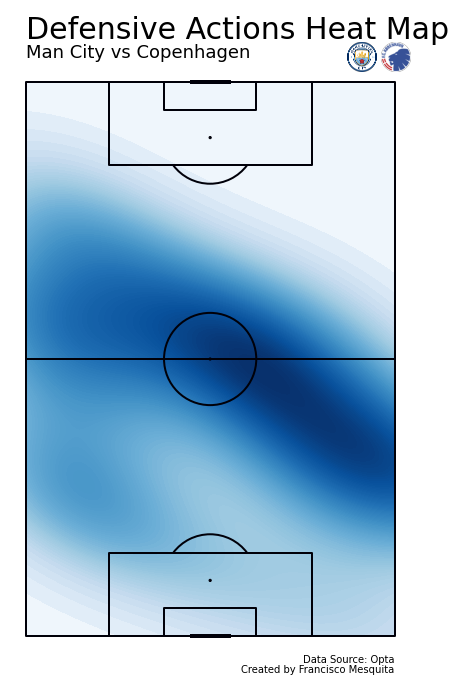

In [84]:
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.82, endnote_height=0.03)
fig.set_facecolor('white')

pitch = VerticalPitch(line_color='#000009', line_zorder=1)

# Home Team
home = df_def[df_def.team_name == data['home']['name']]

kde_HD = pitch.kdeplot(home.x, home.y, ax=axs['pitch'],
                          shade=True, levels=100, shade_lowest=True,
                          cut=4, cmap='Blues')

#axs['title'].text(0.5, 0.1, "Defensive Actions by Man City", color='#000009',
#                  va='center', ha='center', #fontproperties=robotto_regular.prop, 
#                  fontsize=25)

axs['title'].text(0, 0.6, 'Defensive Actions Heat Map', va='center', ha='left', fontsize=30)
axs['title'].text(0, 0.2, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

axs['endnote'].text(1, 0.8, 'Data Source: Opta', va='center', ha='right')
axs['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')

plt.rcParams["figure.figsize"] = [5.00, 1.50]
plt.rcParams["figure.autolayout"] = True


add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.07)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.07)
#imHD = plt.imread('mancity.png') # insert local path of the image.
#newaxHD = fig.add_axes([1.02,0.86,0.1,0.06], anchor='NE', zorder=1)
#newaxHD.imshow(imHD)
#newaxHD.axis('off')

In [33]:
df.type_displayName.unique()

array(['Start', 'Pass', 'KeeperPickup', 'Clearance', 'BallTouch',
       'TakeOn', 'Tackle', 'CornerAwarded', 'SavedShot', 'BallRecovery',
       'MissedShots', 'Aerial', 'BlockedPass', 'Goal', 'Interception',
       'Dispossessed', 'Foul', 'Claim', 'Save', 'Challenge',
       'ChanceMissed', 'End', 'SubstitutionOff', 'SubstitutionOn',
       'FormationChange', 'Card', 'PenaltyFaced', 'ShotOnPost',
       'FormationSet'], dtype=object)

In [34]:
MissedShots = df[df.type_displayName == 'MissedShots'].reset_index()
MissedShots['team_name'] = MissedShots.teamId.apply(lambda x: team_dict[x])
MissedShots['player_name'] = MissedShots.playerId.apply(lambda x: player_dict[x])
MissedShots = MissedShots[MissedShots.team_name == 'Man City']

ShotOnPost = df[df.type_displayName == 'ShotOnPost'].reset_index()
ShotOnPost['team_name'] = ShotOnPost.teamId.apply(lambda x: team_dict[x])
ShotOnPost['player_name'] = ShotOnPost.playerId.apply(lambda x: player_dict[x])
ShotOnPost = ShotOnPost[ShotOnPost.team_name == 'Man City']

SavedShot = df[df.type_displayName == 'SavedShot'].reset_index()
SavedShot['team_name'] = SavedShot.teamId.apply(lambda x: team_dict[x])
SavedShot['player_name'] = SavedShot.playerId.apply(lambda x: player_dict[x])
SavedShot = SavedShot[SavedShot.team_name == 'Man City']

Missed = df[df.type_displayName.isin(['MissedShots', 'ShotOnPost', 'SavedShot'])]
Missed['team_name'] = Missed.teamId.apply(lambda x: team_dict[x])
Missed['player_name'] = Missed.playerId.apply(lambda x: player_dict[x])
Missed = Missed[Missed.team_name == 'Man City']

Goal = df[df.type_displayName == 'Goal'].reset_index()
Goal['team_name'] = Goal.teamId.apply(lambda x: team_dict[x])
Goal['player_name'] = Goal.playerId.apply(lambda x: player_dict[x])
OwnGoal = Goal[Goal.team_name == 'Copenhagen']
Goal = Goal[Goal.team_name == 'Man City']
#Goal
#OwnGoal
Goal

,index,id,playerId,teamId,eventId,minute,second,type_displayName,outcomeType_displayName,x,y,endX,endY,isTouch,team_name,player_name
0,126,2.467647e+09,315227.0,167,105,6,48,Goal,Successful,88.9,46.8,NaN,NaN,True,Man City,Erling Haaland
1,622,2.467659e+09,315227.0,167,455,31,57,Goal,Successful,95.0,43.9,NaN,NaN,True,Man City,Erling Haaland
3,1032,2.467674e+09,104749.0,167,702,54,15,Goal,Successful,88.5,50.0,NaN,NaN,True,Man City,Riyad Mahrez
4,1406,2.467685e+09,365409.0,167,976,75,52,Goal,Successful,95.3,50.3,NaN,NaN,True,Man City,Julián Álvarez


No handles with labels found to put in legend.


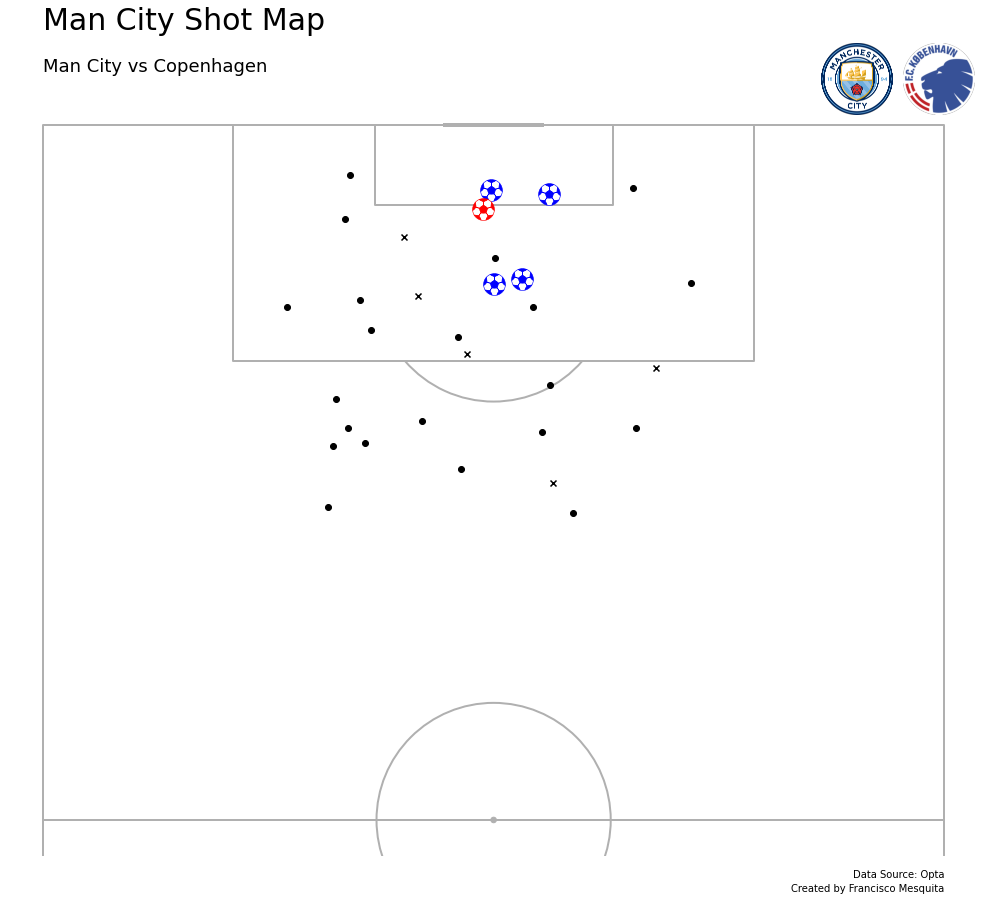

In [35]:
pitch = VerticalPitch(pitch_type='opta', half= True)
#fig, ax = pitch.grid(ncols=1, axis=False)

fig, ax = pitch.grid(figheight=13, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("white")




pitch.scatter(Goal.x, Goal.y, edgecolors='blue', linewidth = 0.6, c = 'white', 
             marker = 'football', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(100-OwnGoal.x, OwnGoal.y, edgecolors='red', linewidth = 0.6, c = 'white', 
             marker = 'football', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(MissedShots.x, MissedShots.y, c = 'black', edgecolors = 'red', #hatch = '///', 
              marker = 'x', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(SavedShot.x, SavedShot.y, c = 'black', edgecolors = 'black', #hatch = '///', 
              marker = 'o', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(ShotOnPost.x, ShotOnPost.y, c = 'black', edgecolors = 'black', #hatch = '///', 
              marker = 'o', ax = ax['pitch'], zorder =2, label='Right Foot')

#pitch.scatter(Missed.x, Missed.y, c = 'black', edgecolors = 'red', #hatch = '///', 
#              marker = 'x', ax = ax['pitch'])#,label='Right Foot')

#scatter_shotsP = pitch.scatter(shots1P.x, shots1P.y, s = (shots1P.shot_statsbomb_xg * 900) + 100, c = 'white', 
#                                edgecolors = 'blue', hatch = '///', marker = 'o', ax = ax['pitch'])

#scatter_goalsP = pitch.scatter(goalsP.x, goalsP.y, s = (goalsP.shot_statsbomb_xg * 900) + 100, edgecolors='blue', 
#                                linewidth = 0.6, c = 'white', marker = 'football', ax = ax['pitch'])

# Legend
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
#ax.legend(handles=[barplt,normplt[0]])    

ax['title'].text(0, 0.9, 'Man City Shot Map', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

#add_image(Image.open('mancity.png'), fig, 
#          left=0.5, bottom=0.9, width=0.1, height=0.05)

# add a legend and title
legend = axs['pitch'].legend(loc = (0.65,.24), labelspacing = 1.5, fontsize = 15)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.09)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.09)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')


plt.show()

No handles with labels found to put in legend.


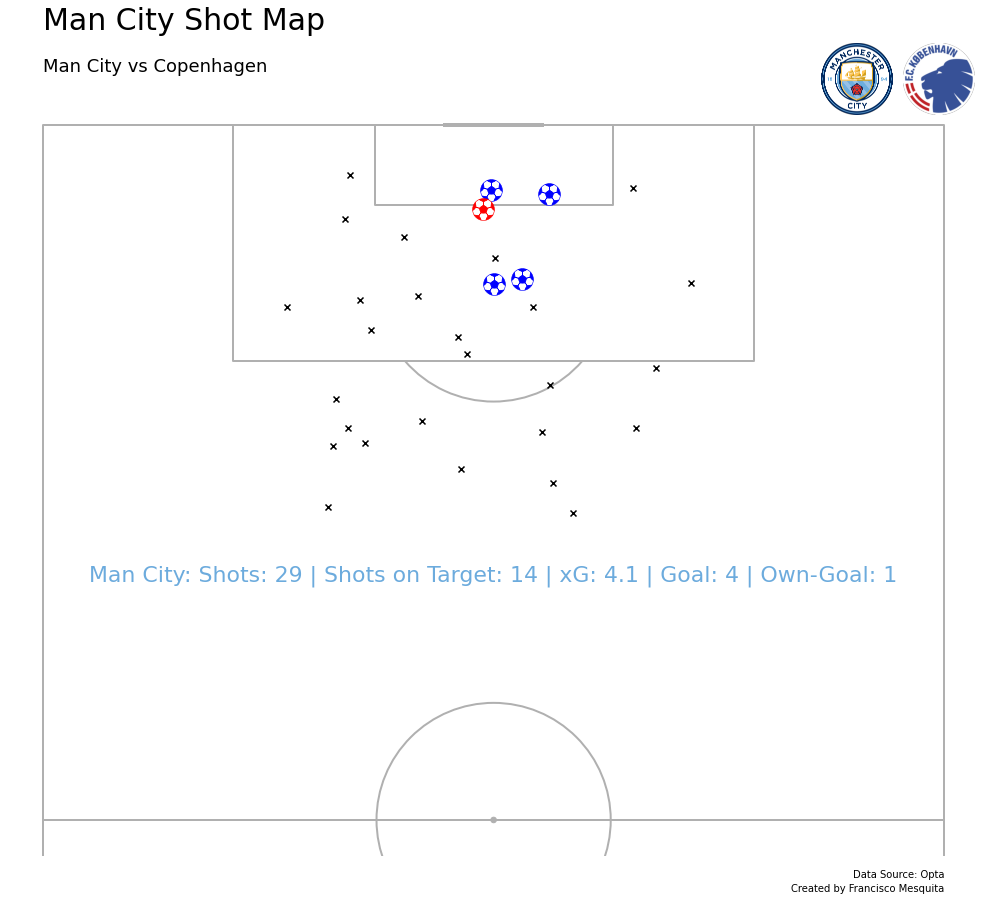

In [74]:
pitch = VerticalPitch(pitch_type='opta', half= True)
#fig, ax = pitch.grid(ncols=1, axis=False)

fig, ax = pitch.grid(figheight=13, title_height=0.08, endnote_space=0, axis=False, 
                      title_space=0, grid_height=0.82, endnote_height=0.05)

fig.set_facecolor("white")




pitch.scatter(Goal.x, Goal.y, edgecolors='blue', linewidth = 0.6, c = 'white', 
             marker = 'football', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(100-OwnGoal.x, OwnGoal.y, edgecolors='red', linewidth = 0.6, c = 'white', 
             marker = 'football', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(MissedShots.x, MissedShots.y, c = 'black', edgecolors = 'red', #hatch = '///', 
              marker = 'x', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(SavedShot.x, SavedShot.y, c = 'black', edgecolors = 'black', #hatch = '///', 
              marker = 'x', ax = ax['pitch'], zorder =2, label='Right Foot')

pitch.scatter(ShotOnPost.x, ShotOnPost.y, c = 'black', edgecolors = 'black', #hatch = '///', 
              marker = 'x', ax = ax['pitch'], zorder =2, label='Right Foot')

#pitch.scatter(Missed.x, Missed.y, c = 'black', edgecolors = 'red', #hatch = '///', 
#              marker = 'x', ax = ax['pitch'])#,label='Right Foot')

#scatter_shotsP = pitch.scatter(shots1P.x, shots1P.y, s = (shots1P.shot_statsbomb_xg * 900) + 100, c = 'white', 
#                                edgecolors = 'blue', hatch = '///', marker = 'o', ax = ax['pitch'])

#scatter_goalsP = pitch.scatter(goalsP.x, goalsP.y, s = (goalsP.shot_statsbomb_xg * 900) + 100, edgecolors='blue', 
#                                linewidth = 0.6, c = 'white', marker = 'football', ax = ax['pitch'])

# Legend
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
#ax.legend(handles=[barplt,normplt[0]])    

ax['title'].text(0, 0.9, 'Man City Shot Map', va='center', ha='left', fontsize=30)
ax['title'].text(0, 0.3, data['home']['name'] + ' vs ' + data['away']['name'], va='center', ha='left', fontsize=18)

#add_image(Image.open('mancity.png'), fig, 
#          left=0.5, bottom=0.9, width=0.1, height=0.05)

# add a legend and title
legend = axs['pitch'].legend(loc = (0.65,.24), labelspacing = 1.5, fontsize = 15)

add_image(Image.open('mancity.png'), fig, 
          left=0.82, bottom=0.86, width=0.07, height=0.09)
add_image(Image.open('copenhagen.png'), fig, 
          left=0.9, bottom=0.86, width=0.07, height=0.09)

ax['endnote'].text(1, 0.6, 'Data Source: Opta', va='center', ha='right')
ax['endnote'].text(1, 0.3, 'Created by Francisco Mesquita', va='center', ha='right')



ax['title'].text(0.5, -6.5, "Man City: Shots: 29 | Shots on Target: 14 | xG: 4.1 | Goal: 4 | Own-Goal: 1", 
                 color = '#6CABDD', va = 'center', ha = 'center', fontsize = 22)

plt.show()